## Setups

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from src.EEGModalNet.models.WGAN import WGAN_GP
from tqdm.auto import tqdm


# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, ch=0, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, :, [ch]].flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen, ch=0):
    x, x_gen = x[:, :, [ch]], x_gen[:, :, [ch]]
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_psd4subjects_channel(xarray, n_subjects=20, ch_list=['O1'], fmin=1, fmax=64):
    sub_ids = xarray.subject[:n_subjects].to_numpy()
    x = xarray.sel(subject=xarray.subject[:n_subjects]).to_numpy()
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, fmin=fmin, fmax=fmax, n_fft=512)
    psd = 10*np.log10(psd.squeeze(1))
    for i in range(psd.shape[0]):
        plt.plot(freq, psd[i])
        # stick the channel name to the corresponding line
        for i in range(len(sub_ids)):
            plt.text(60, psd[i, -1], sub_ids[i], fontsize=8)
        plt.xlabel('Frequency (Hz)')

def plot_raw4subject_channel(xarray, sub, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

def get_data_gender_wise(xarray, gender, random_draw=False, n_subjects=20, slicer=0):
    chunk = slicer*n_subjects
    inx = 1 if gender == 'M' else 2
    ids = np.where(xarray.gender == inx)[0]
    assert chunk < len(ids), 'There is no more data to draw from'
    ids = np.random.choice(ids, n_subjects, replace=False) if random_draw else ids[chunk:n_subjects+chunk]
    return xarray.sel(subject=xarray.subject[ids]), xarray.subject[ids]

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [2]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channels = ['F1', 'O1']
processed = False
filtering = True
choose_gender_wise = True
time_dim = 1024
n_subject = 30
data_chunck = 0

if processed:
    data_ec = {}

    # read epochs data with mne
    for i in Path(data_path).glob('sub-01000*_EC.set'):
        sub_id = i.stem
        raw_ec = mne.io.read_raw_eeglab(i, verbose=False)
        if all(item in raw_ec.ch_names for item in channels):
            raw_ec = raw_ec.pick(channels).get_data()
            data_ec[sub_id] = raw_ec
        else:
            print("Not all items in Channels exist in Raw data, will skip this subject")
            continue

    data = {k: torch.tensor(v).unfold(1, time_dim, time_dim).permute(1, 2, 0) for k, v in data_ec.items()}
    del data_ec

    # create sub_ids
    sub_ids = np.array([]).astype(int)
    for i, k in enumerate(data.keys()):
        sub_ids = np.concatenate((sub_ids, np.array([int(i)]*data[k].shape[0], dtype=int)), dtype=int)

    sub_ids = sub_ids[:, np.newaxis]

    # sanity check
    print(np.unique(sub_ids, return_counts=True))

    x = np.zeros([1, time_dim, 1])
    for k in data.keys():
        x = np.concatenate((x, data[k]), axis=0)
    x = x[1:]
    data = {'x': x, 'sub': sub_ids}

else:
    # data
    data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
    xarray = xr.open_dataarray(data_path, engine='h5netcdf')

    if choose_gender_wise:
        xm, male_ids = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        xf, female_ids = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        x = xr.concat([xm, xf], dim='subject').to_numpy()
        sub_ids = xarray.subject[:n_subject].to_numpy()
    
    else:
        sub_ids = xarray.subject[:n_subject].to_numpy()
        x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()

    ch_list = channels
    ch_ind = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ind, 440:]
    if filtering:
        x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
    sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
    pos = xarray.ch_positions[ch_ind][None].repeat(x.shape[0], 0)
    data = {'x': x, 'sub': sub, 'pos': pos}

### Data Quality Check

Effective window size : 4.000 (s)


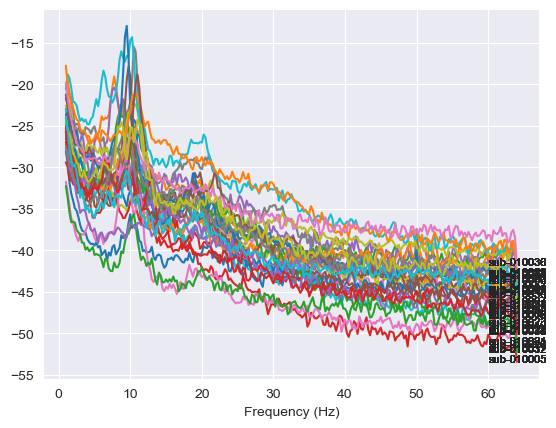

In [49]:
# make sure the PSD of the data across all the recordings is in the right shape
ch_num = 0
plot_psd4subjects_channel(xarray, n_subjects=30, ch_list=channels[ch_num], fmin=1, fmax=64)

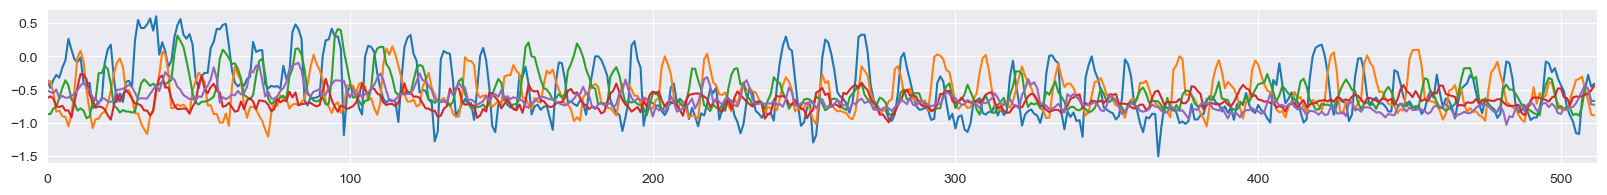

In [4]:
# inspect the data with deviant channel in time domain
sub_id = 'sub-010024'
plot_raw4subject_channel(xarray, sub=sub_id, chann_list=channels[0], start=0, filter=False, filter_range=[1, 60])

In [5]:
# check if this specific channel is excluded in LEMON preprocessed dataset
excluded_chs = pd.read_csv('data/LEMON_data/excluded_channels_ec.csv', index_col=0)
excluded_chs.loc[male_ids.values]

,bad_channels
sub-010042,"['FC1', 'PO7']"
sub-010044,"['Fp1', 'O1']"
sub-010045,NaN
sub-010047,NaN
sub-010048,NaN
sub-010049,NaN
sub-010050,"['FC1', 'C1']"
sub-010062,"['FC1', 'T8', 'PO10']"
sub-010064,NaN
sub-010068,"['T7', 'T8']"


## TRAINING

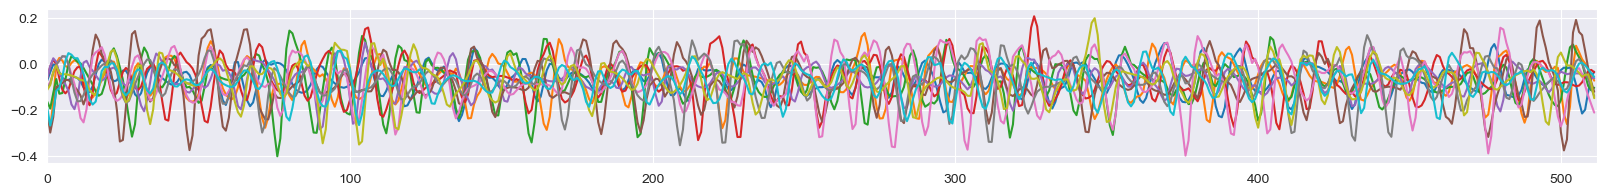

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


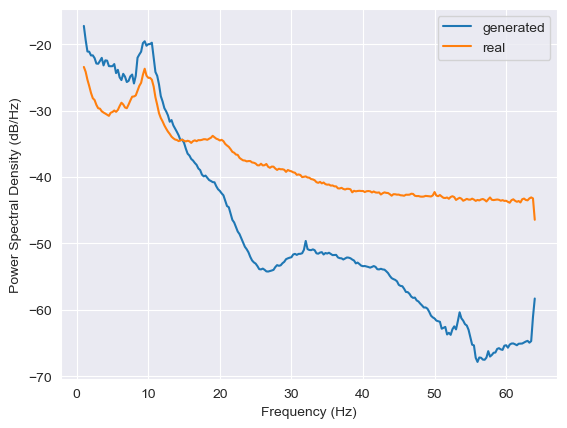

In [5]:
# 2. MODEL and Plot generated data by the model before training
load_model = True
latent_dim = 128
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=True, kerner_initializer='random_normal')
if load_model:
    wgan_gp.load_weights('data/trainings/training_29082024/models/Multich_chF1-O1_sub20_epo140.model.keras')

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
plot_psd(x_gen, fmin=1, ch=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [6]:
# torch.cuda.empty_cache() # clear GPU memory before training
step_loss_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=1.0)

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500)

In [7]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=150, batch_size=batch_size, callbacks=[step_loss_history, early_stopping], shuffle=True)

Epoch 1/150


/opt/homebrew/Caskroom/miniforge/base/envs/eegnet-keras3/lib/python3.11/site-packages/keras/src/backend/torch/optimizers/torch_adam.py:35: UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - critic_grad_norm: 1.1299 - d_loss: -0.3661 - g_loss: 0.7691
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - critic_grad_norm: 1.0152 - d_loss: -0.3968 - g_loss: -0.5022
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - critic_grad_norm: 1.0699 - d_loss: -0.4026 - g_loss: 2.0547
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - critic_grad_norm: 1.1020 - d_loss: -0.3439 - g_loss: -5.4408
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - critic_grad_norm: 1.1782 - d_loss: -0.4656 - g_loss: 6.3523
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - critic_grad_norm: 1.1179 - d_loss: -0.4974 - g_loss: -5.0069
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - critic_grad_norm: 1.0960 - d_loss: -0.5129 - g_loss: 3.9898
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - critic_grad_norm: 1.0982 - d_loss: -0.4881 - g_loss: -7.4403
Epoch 9/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - critic_grad_norm: 1.1222 - d_loss

Text(0.5, 1.0, 'Critic Gradient Norm')

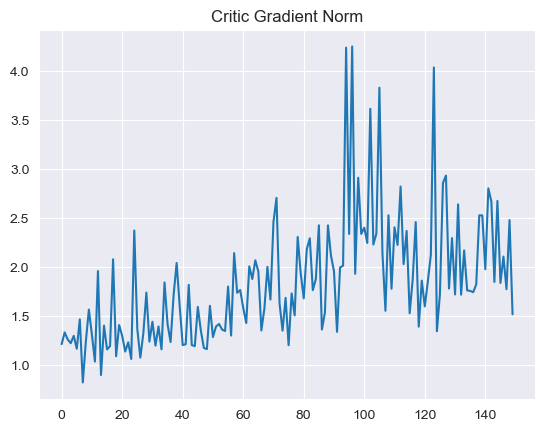

In [8]:
plt.plot(history.history['critic_grad_norm'])
plt.title('Critic Gradient Norm')

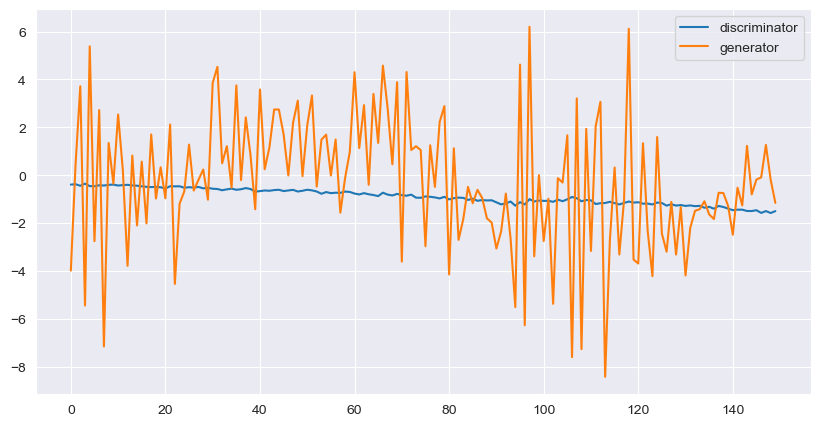

In [9]:
plot_history(history)

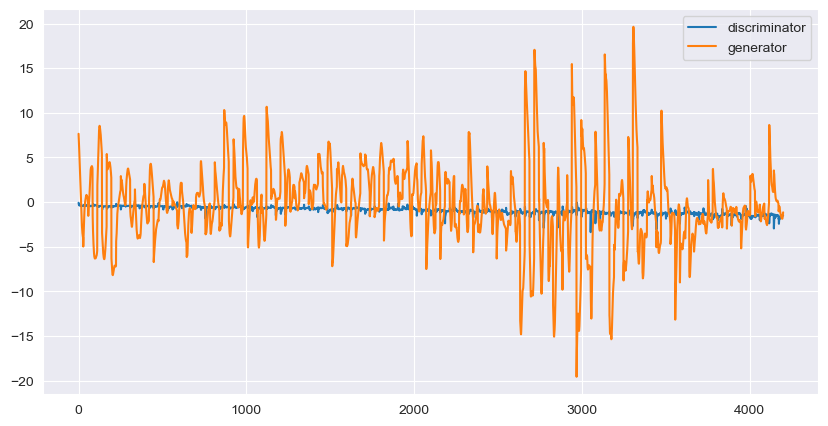

In [10]:
plot_step_losses(step_loss_history)

In [11]:
save_step_losses(step_loss_history.step_losses, filename='data/trainings/training_29082024/step_losses/step_losses_3.json')
wgan_gp.save('data/trainings/training_29082024/models/Multich_chF1-O1_sub20_epo390.model.keras')

## Evaluations & Visualisations

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(wgan_gp.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).mean().item()), sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())

(0.008701342948437107, 0.07290275497580362)

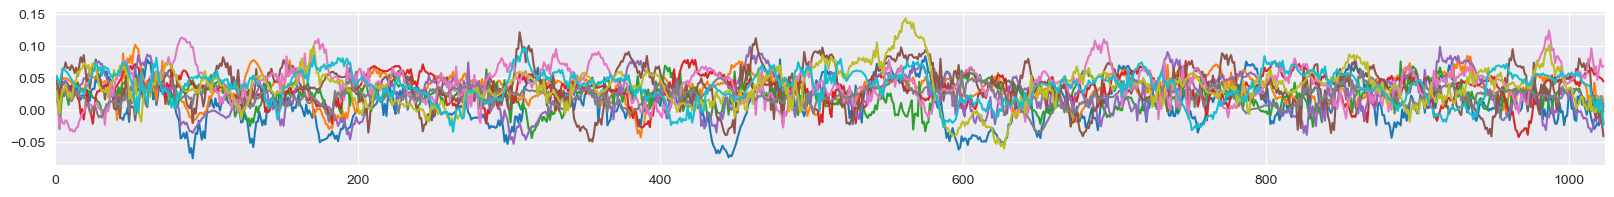

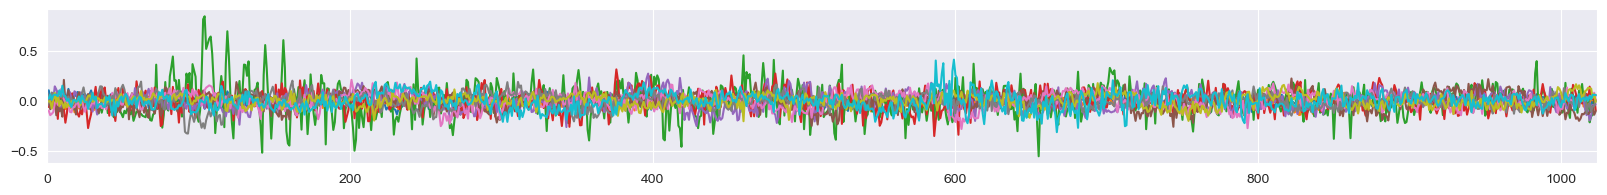

In [16]:
ch = 1
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()),
                          torch.tensor(sub).to('mps'), pos).cpu().detach()
# x_gen = wgan_gp.generator.sub_layer(x_gen.to('mps'), torch.tensor(sub).to('mps')).cpu().detach()
# filter the generated data and real data
# x_gen = mne.filter.filter_data(x_gen.numpy().astype('float'), 128, 1, 20, method='fir', verbose=False)
# x = mne.filter.filter_data(x.numpy(), 128, 1, 20, method='fir', verbose=False)
plot_overlap(x_gen, n_seg=10, ch=ch, start_from=20, time_dim=1024, show=False)
plot_overlap(x, n_seg=10, ch=ch, start_from=20, time_dim=1024, show=False)
plt.show()

### PSDs

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


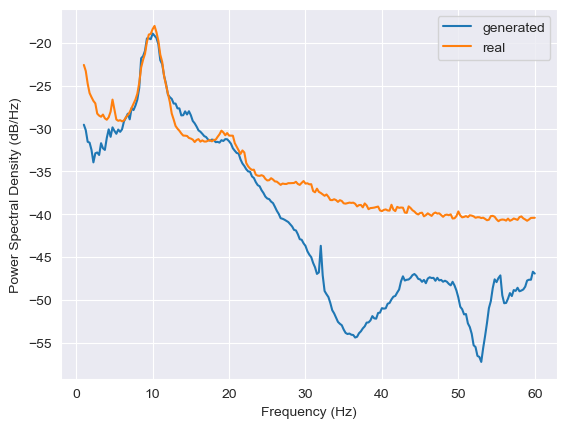

In [17]:
ch = 0
plot_psd(x_gen, fmin=1, ch=ch, fmax=60, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=ch, fmax=60, n_fft=512, label='real', show=True)
plt.show()

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


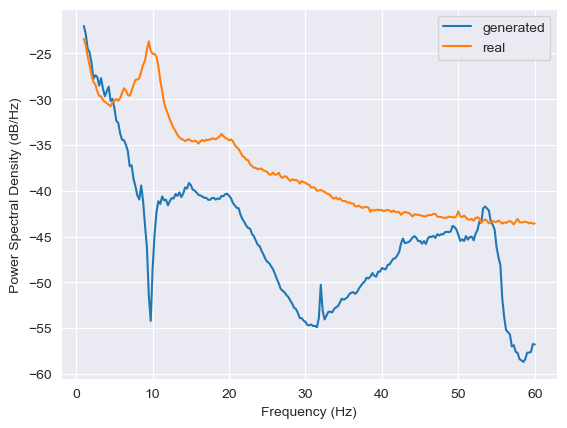

In [18]:
ch = 1
plot_psd(x_gen, fmin=1, ch=ch, fmax=60, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=ch, fmax=60, n_fft=512, label='real', show=True)
plt.show()

### tSNE

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3540 samples in 0.001s...
[t-SNE] Computed neighbors for 3540 samples in 0.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3540
[t-SNE] Computed conditional probabilities for sample 2000 / 3540
[t-SNE] Computed conditional probabilities for sample 3000 / 3540
[t-SNE] Computed conditional probabilities for sample 3540 / 3540
[t-SNE] Mean sigma: 0.252200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.816025
[t-SNE] KL divergence after 1000 iterations: 3.047950


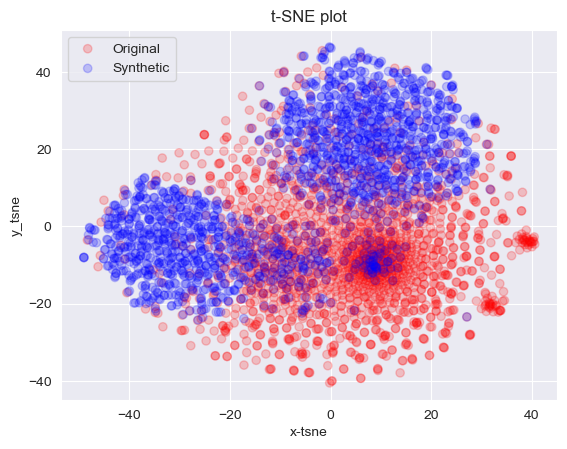

In [20]:
plot_tsne(x, x_gen, ch=0)

## Visualize each layer of Critic's and Generator's output

### Generator

In [22]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()

outputs's shape: (1770, 256)


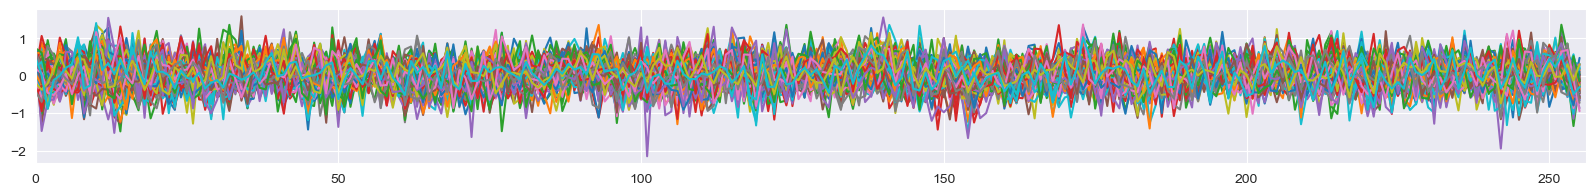

In [23]:
generator = wgan_gp.generator
out = keras.Model(generator.model.layers[0].input, generator.model.layers[2].output)
features = out(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
# features = generator.sub_layer(features, torch.tensor(sub).to('mps')).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Critic

outputs's shape: (1770, 32)


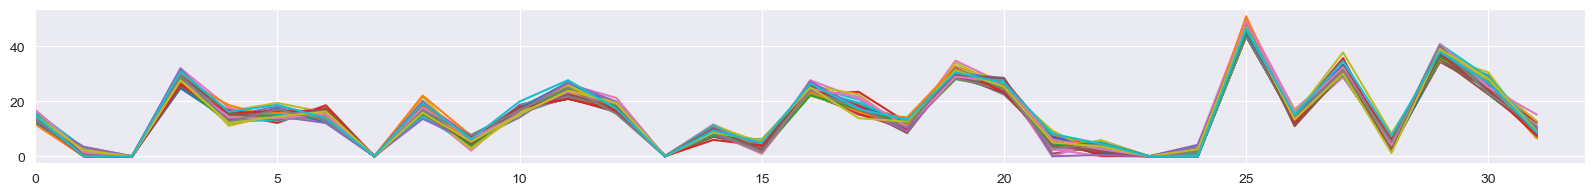

In [25]:
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[-4].output)
features = model(x.float()).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Position layer

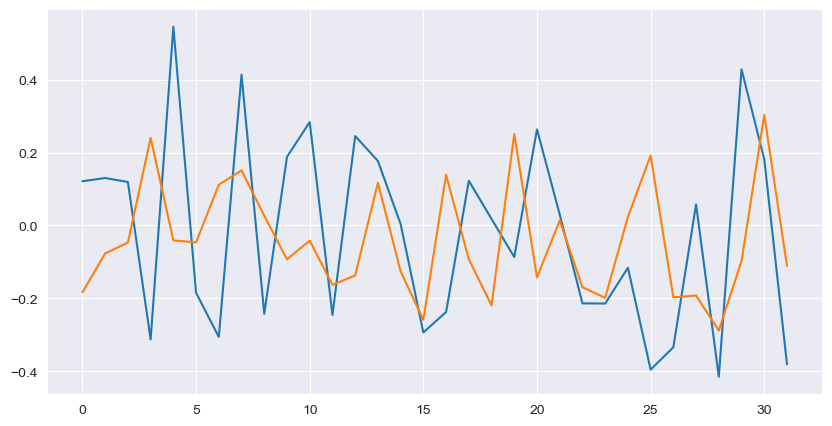

In [26]:
emb2 = wgan_gp.generator.pos_emb.get_weights()[0]
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.plot(emb2[i, :])

## Feature extraction

In [27]:
### Gender Classification
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

# helper functions
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    x = x[ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(0, seg_size, seg_size).permute(0, 2, 1)
    return x

def take_ids(sub_ids):
    return np.array([int(i.split('-')[1][-3:]) for i in sub_ids.to_numpy()])

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def get_data_gender_wise(xarray, gender, random_draw=False, n_subjects=20):
    inx = 1 if gender == 'M' else 2
    ids = np.where(xarray.gender == inx)[0]
    ids = np.random.choice(ids, n_subjects, replace=False) if random_draw else ids[:n_subjects]
    return xarray.sel(subject=xarray.subject[ids]), xarray.subject[ids]

In [28]:
# open data and gender data
# gender classification
ch_list = ['F1', 'O1']
time_dim = 1024
take_rnd = 20
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=True, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=True, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

In [32]:
# upload the model
# model = WGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=64, n_subjects=20, use_sublayers=True)
# model.load_weights('tmp/keras_models/wgan_gp_with_sub_layer.model.keras')
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[-4].output)
# x_ = critic.sub_layer(x.float().to('mps'), torch.tensor(sub).to('mps'))
features = model(x.float()).cpu().detach().numpy()
features.shape

(2360, 32)

In [33]:
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 48.60% ±8.34%


In [134]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

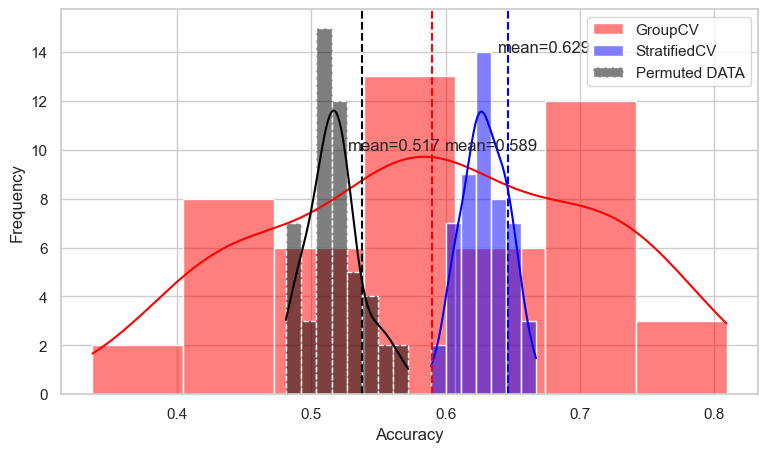

In [135]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### Ensemble networks

In [68]:
# 1. DATA
# open data and gender data
# gender classification
ch_list = ['O1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

# concate features from different networks
wgan = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=30, use_sublayer_generator=True)
wgan.load_weights('data/trainings/training_23082024/model/mostpromising_withsublayerInGenerator_chO1_sub30_epo100_trained_with_different_data.model.keras')

mode1_o1 = wgan.critic
mode1_o1 = keras.Model(inputs=mode1_o1.model.layers[0].input, outputs=mode1_o1.model.layers[-5].output)
features_o1 = mode1_o1(x.float()).cpu().detach().numpy()

In [64]:
ch_list = ['F1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

wgan_f1 = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=40, use_sublayer_generator=True)
wgan_f1.load_weights('data/trainings/training_25082024/models/withResidualsInCriticV2_chF1_sub40_epo1381.model.keras')
model_f1 = wgan_f1.critic
model_f1 = keras.Model(inputs=model_f1.model.layers[0].input, outputs=model_f1.model.layers[-5].output)
features_f1 = model_f1(x.float()).cpu().detach().numpy()

In [58]:
# concate features
features = np.concatenate((features_o1, features_f1), axis=1)

In [69]:
features = features_o1
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 53.28% ±7.56%


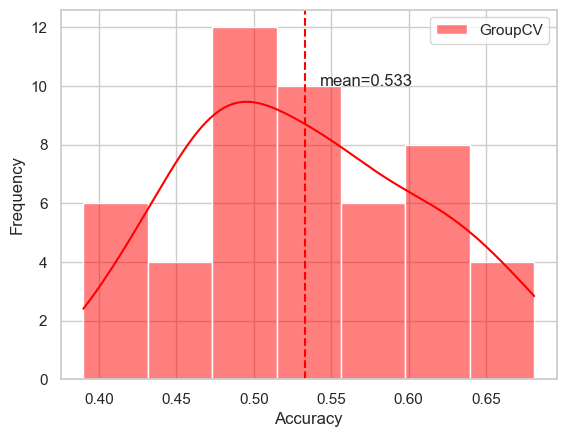

In [70]:
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

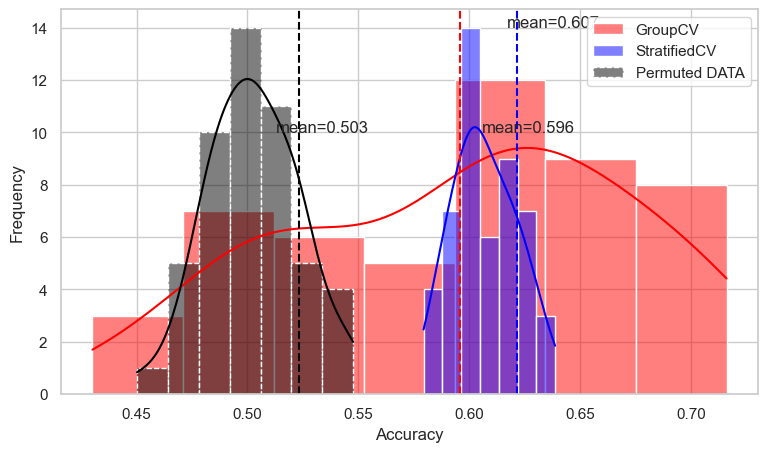

In [63]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

In [62]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

### Notes
using the final output of the critic, results in a highest accuracy!! (could not replicate this result!)
it seems that the conv layers of the critic are responsible for getting similar outputs from different layers.


## DEBUG

In [51]:
import math
import typing as tp
from typing import List, Union
import mne
import torch
from torch import nn
import keras
from keras import layers

class PositionGetter:
    INVALID = -0.1

    def __init__(self) -> None:
        self._cache: tp.Dict[int, torch.Tensor] = {}
        self._invalid_names: tp.Set[str] = set()

    def get_recording_layout(self, info) -> torch.Tensor:
        layout = mne.channels.find_layout(info)
        positions = torch.full((len(info.ch_names), 2), self.INVALID)
        x, y = layout.pos[:, :2].T
        x = (x - x.min()) / (x.max() - x.min())
        y = (y - y.min()) / (y.max() - y.min())
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        positions[:, 0] = x
        positions[:, 1] = y
        return positions

    def get_positions(self, batch):
        eeg, _, info = batch
        B, C, _ = eeg.shape
        positions = torch.full((B, C, 2), self.INVALID, device=eeg.device)
        for idx in range(len(batch)):
            # recording = batch._recordings[idx]
            rec_pos = self.get_recording_layout(info)
            positions[idx, :len(rec_pos)] = rec_pos.to(eeg.device)
        return positions

    def is_invalid(self, positions):
        return (positions == self.INVALID).all(dim=-1)


class FourierEmb(nn.Module):
    """
    Fourier positional embedding.
    Unlike trad. embedding this is not using exponential periods
    for cosines and sinuses, but typical `2 pi k` which can represent
    any function over [0, 1]. As this function would be necessarily periodic,
    we take a bit of margin and do over [-0.2, 1.2].
    """
    def __init__(self, dimension: int = 256, margin: float = 0.2):
        super().__init__()
        n_freqs = (dimension // 2)**0.5
        assert int(n_freqs ** 2 * 2) == dimension
        self.dimension = dimension
        self.margin = margin

    def forward(self, positions):
        *O, D = positions.shape
        assert D == 2
        n_freqs = (self.dimension // 2)**0.5
        freqs_y = torch.arange(n_freqs).to(positions)
        freqs_x = freqs_y[:, None]
        width = 1 + 2 * self.margin
        positions = positions + self.margin
        p_x = 2 * math.pi * freqs_x / width
        p_y = 2 * math.pi * freqs_y / width
        positions = positions[..., None, None, :]
        loc = (positions[..., 0] * p_x + positions[..., 1] * p_y).view(*O, -1)
        emb = torch.cat([
            torch.cos(loc),
            torch.sin(loc),
        ], dim=-1)
        return emb


class ChannelMerger(nn.Module):
    def __init__(self, chout: int, pos_dim: int = 256,
                 dropout: float = 0, usage_penalty: float = 0.,
                 n_subjects: int = 200, per_subject: bool = False):
        super().__init__()
        assert pos_dim % 4 == 0
        self.position_getter = PositionGetter()
        self.per_subject = per_subject
        if self.per_subject:
            self.heads = nn.Parameter(torch.randn(n_subjects, chout, pos_dim, requires_grad=True))
        else:
            self.heads = nn.Parameter(torch.randn(chout, pos_dim, requires_grad=True))
        self.heads.data /= pos_dim ** 0.5
        self.dropout = dropout
        self.embedding = FourierEmb(pos_dim)
        self.usage_penalty = usage_penalty
        self._penalty = torch.tensor(0.)

    @property
    def training_penalty(self):
        return self._penalty.to(next(self.parameters()).device)

    def forward(self, eeg, positions):
        eeg = eeg.permute(0, 2, 1)
        B, C, T = eeg.shape
        eeg = eeg.clone()
        # positions = self.position_getter.get_positions(batch)
        embedding = self.embedding(positions)
        score_offset = torch.zeros(B, C, device=eeg.device)
        # score_offset[self.position_getter.is_invalid(positions)] = float('-inf')

        if self.training and self.dropout:
            center_to_ban = torch.rand(2, device=eeg.device)
            radius_to_ban = self.dropout
            banned = (positions - center_to_ban).norm(dim=-1) <= radius_to_ban
            score_offset[banned] = float('-inf')

        if self.per_subject:
            _, cout, pos_dim = self.heads.shape
            subject = batch.subject_index
            heads = self.heads.gather(0, subject.view(-1, 1, 1).expand(-1, cout, pos_dim))
        else:
            heads = self.heads.unsqueeze(0).repeat(B, 1, 1)

        scores = torch.einsum("bcd,bod->boc", embedding, heads)
        scores += score_offset[:, None]
        weights = torch.softmax(scores, dim=2)
        out = torch.einsum("bct,boc->bot", eeg, weights)
        if self.training and self.usage_penalty > 0.:
            usage = weights.mean(dim=(0, 1)).sum()
            self._penalty = self.usage_penalty * usage
        return out

In [ ]:
heads = nn.Parameter(torch.randn(2, 4, requires_grad=True))
heads.data /= 4 ** 0.5

heads = heads.unsqueeze(0).repeat(118, 1, 1)
embedding = FourierEmb(4)
emb = embedding(pos)

scores = torch.einsum("bcd,bod->boc", emb, heads)
scores.shape

In [52]:
pos_emb = ChannelMerger(
                chout=2, pos_dim=72, n_subjects=2
            ) 
x_ = pos_emb(x.float(), torch.tensor(pos)).permute(0, 2, 1)

tensor(-10112.5508, grad_fn=<SumBackward0>)
tensor(-10112.5508, grad_fn=<SumBackward0>)


Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


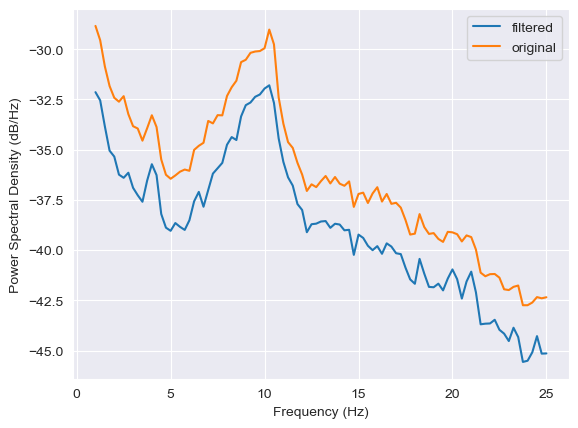

In [31]:
plot_psd(x_.cpu().detach(), fmin=1, fmax=25, n_fft=512, label='filtered', show=False)
plot_psd(x, fmin=1, fmax=25, n_fft=512, label='original', show=True)